In [33]:
import torch
from d2l import torch as d2l
import random

In [5]:
tokens = d2l.tokenize(d2l.read_time_machine())
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

In [6]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

32775


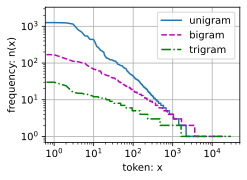

In [23]:
trigram_tokens = [tuple(corpus[st:st+3]) for st in range(0, len(corpus))]
print(len(trigram_tokens))
# trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
# print(len(trigram_tokens))

trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]
freqs = [freq for token, freq in vocab.token_freqs]
# plot the figure
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
            ylabel='frequency: n(x)', xscale='log', yscale='log',
            legend=['unigram', 'bigram', 'trigram'])

In [27]:
def seq_data_iter_sequential(corpus, batch_size, num_steps): #@save
    """使⽤顺序分区⽣成⼀个⼩批量⼦序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
    yield X, Y

In [35]:
def seq_data_iter_random(corpus, batch_size, num_steps): #@save
    """使⽤随机抽样⽣成⼀个⼩批量⼦序列"""
    # 从随机偏移量开始对序列进⾏分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # ⻓度为num_steps的⼦序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来⾃两个相邻的、随机的、⼩批量中的⼦序列不⼀定在原始序列上相邻
    random.shuffle(initial_indices)
    def data(pos):
        # 返回从pos位置开始的⻓度为num_steps的序列
        return corpus[pos: pos + num_steps]
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这⾥， initial_indices包含⼦序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [39]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


In [40]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[24, 25, 26, 27, 28],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[25, 26, 27, 28, 29],
        [20, 21, 22, 23, 24]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [ 4,  5,  6,  7,  8]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [ 5,  6,  7,  8,  9]])
X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


In [41]:
class SeqDataLoader: #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
            self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
            self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)
